## Setup

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu')

# Note, must run the experiments with cpu otherwise guidedbackprop will be wrong

In [ ]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
checkpoint_dir = "/content/gdrive/My Drive/CSC413 Project/"

In [9]:
torch.manual_seed(413)
np.random.seed(413)

### Utilities for Visualization

This code is taken from the repo https://github.com/utkuozbulak/pytorch-cnn-visualizations

In [2]:
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map

import torch
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('results'):
        os.makedirs('results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('results', file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def save_image(im, path):
    """
        Saves a numpy matrix of shape D(1 or 3) x W x H as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, np.ndarray):
        if len(im.shape) == 2:
            im = np.expand_dims(im, axis=0)
        if im.shape[0] == 1:
            # Converting an image with depth = 1 to depth = 3, repeating the same values
            # For some reason PIL complains when I want to save channel image as jpg without
            # additional format in the .save()
            im = np.repeat(im, 3, axis=0)
            # Convert to values to range 1-255 and W,H, D
        if im.shape[0] == 3:
            im = im.transpose(1, 2, 0) * 255
        im = Image.fromarray(im.astype(np.uint8))
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((512, 512))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_ten.requires_grad = True
    im_as_var = im_as_ten
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def normalize_gradient_image(gradient):
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    
    return gradient

## Dataloaders

### MNIST Dataloader

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-20 19:30:04--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-20 19:30:05--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [          <=>       ]  33.20M  16.3MB/s    in 2.0s    

2021-04-20 19:30:07 (16.3 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [ ]:
# Dataset
train_dataset = datasets.MNIST(root='./', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./', train=False, transform=transforms.ToTensor())

# Dataloader
batch_size = 32  
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### CIFAR-10 Dataloader

In [ ]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Classes of images
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Read in the training & testing data
batch_size = 32

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([3, 224, 224])
deer, bird, bird, horse, ship, horse, car, horse, cat, truck, horse, truck, car, frog, cat, bird, ship, plane, dog, deer, dog, truck, plane, horse, frog, horse, plane, bird, bird, ship, plane, ship


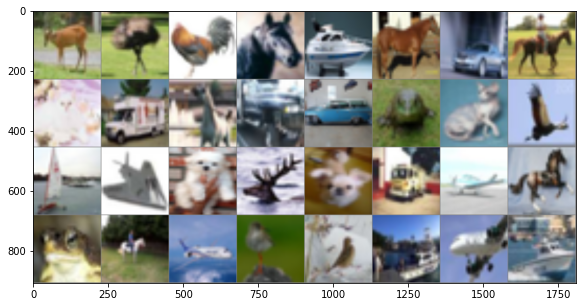

In [ ]:
# Let's look at some example training images
dataiter = iter(trainloader)      # For training images
testdataiter = iter(testloader)   # For testing images (used later)
images, labels = dataiter.next()  # Ask the iterator for some images

print(images[0].shape)

iterBatchSize = 32  # TODO: Check this?
# Show images and labels
plt.figure(figsize=(10,5))
plt.imshow(np.transpose(torchvision.utils.make_grid(images).numpy() / 2 + 0.5, (1, 2, 0)))
print(', '.join(classes[labels[j]] for j in range(iterBatchSize)))

##Model

In [ ]:
# Save checkpoint
def save_checkpoint(net, epoch, path="model.pt"):
  torch.save({
              'epoch': epoch+1,
              'model_state_dict': net.state_dict(),
              }, path)
  
def load_checkpoint(net, path="model.pt"):
  if torch.cuda.is_available():
    checkpoint = torch.load(path)
  else:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
  net.load_state_dict(checkpoint['model_state_dict'])
  epoch = checkpoint['epoch']
  return epoch

###Finetuning Alexnet (entire network)

In [ ]:
num_classes = 10

net = models.alexnet(pretrained=True)
num_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs,num_classes)

net = net.to(device)
print(net)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

LOAD_CHECKPOINT = True

if LOAD_CHECKPOINT:
  epoch = load_checkpoint(net, os.path.join(checkpoint_dir, "model.pt"))
else:
  net.train()

  for epoch in range(10):
      running_loss = 0.0
      num_total = 0.0
      num_correct = 0.0

      for i, (inputs, labels) in enumerate(trainloader, 0):
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = net(inputs)              # Forward
          loss = criterion(outputs, labels)  # Compute loss
          optimizer.zero_grad()              # Zero the parameter gradients
          loss.backward()                    # Backward
          optimizer.step()                   # Gradient step

          num_correct += (torch.argmax(outputs, dim=1) == labels).sum().float()
          num_total += labels.size(0)
          
          # Print statistics
          running_loss += loss.item()
          if (i+1) % 1000 == 0:    # print every 2000 mini-batches
              print('[{}, {:5d}] loss: {:6.4f}, acc: {:6.4f}'.format(
                    epoch + 1, i + 1, running_loss / 2000, num_correct / num_total))
              running_loss = 0.0

  print('Finished Training')

  save_checkpoint(net, epoch)
  print('Saved checkpoint')

###Test Accuracy

In [ ]:
net.eval()

# Overall accuracy on the test set
correct, total = 0, 0
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    predicted = torch.argmax(outputs, dim=1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Accuracy on test set: %d %%' % (100 * correct / total))

Accuracy on test set: 91 %


In [ ]:
# Accuracies per class
nClasses = 10
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    predicted = torch.argmax(outputs, dim=1)
    c = (predicted == labels).squeeze()

    for i in range(labels.size(0)):
        label = labels[i]
        class_correct[label] += c[i].float()
        class_total[label] += 1

for i in range(nClasses):
    print('Accuracy of {} : {:6.2f}'.format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane :  93.70
Accuracy of car :  96.60
Accuracy of bird :  92.40
Accuracy of cat :  85.00
Accuracy of deer :  91.90
Accuracy of dog :  80.00
Accuracy of frog :  93.90
Accuracy of horse :  89.60
Accuracy of ship :  96.20
Accuracy of truck :  93.40


## Saliency Methods

### Guided Backprop

In [ ]:
from torch.nn import ReLU

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        one_hot_output = one_hot_output
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

### Grad Cam

In [ ]:
from scipy.ndimage import zoom

class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None, cuda=torch.cuda.is_available()):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        if cuda:
          one_hot_output = one_hot_output.to(device)
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.cpu().numpy()[0]
        # Get convolution outputs
        target = conv_output.data.cpu().numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        # cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        # cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        # cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
        #                input_image.shape[3]), Image.ANTIALIAS))
        # # ^ In order to use resizing with ANTIALIAS feature of PIL,
        # # briefly convert matrix to PIL image and then back.
        # cam = np.asarray(cam, dtype=np.float64)
        
        # spline interpolation
        scale = tuple(input_image.shape[2] / cam.shape[i] for i in range(len(cam.shape)))
        cam = zoom(cam, scale)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        
        return cam

In [ ]:
def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and
        guided backprop mask
    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb

### SmoothGrad

In [ ]:
# from https://github.com/hs2k/pytorch-smoothgrad

from torch.autograd import Variable

class SmoothGrad(object):

    def __init__(self, pretrained_model, cuda=False, stdev_spread=0.15,
                 n_samples=25, magnitude=True):
        #super(SmoothGrad, self).__init__(pretrained_model, cuda)
        
        self.pretrained_model = pretrained_model
        self.features = pretrained_model.features
        self.cuda = cuda
        self.pretrained_model.eval()
        
        self.stdev_spread = stdev_spread
        self.n_samples = n_samples
        self.magnitutde = magnitude

    def generate_gradients(self, x, target_class=None):
        x = x.data.cpu().numpy()
        stdev = self.stdev_spread * (np.max(x) - np.min(x))
        total_gradients = np.zeros_like(x)
        for i in range(self.n_samples):
            noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
            x_plus_noise = x + noise
            if self.cuda:
                x_plus_noise = Variable(torch.from_numpy(x_plus_noise).cuda(), requires_grad=True)
            else:
                x_plus_noise = Variable(torch.from_numpy(x_plus_noise), requires_grad=True)
            output = self.pretrained_model(x_plus_noise)

            if target_class is None:
                target_class = np.argmax(output.data.cpu().numpy())

            one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
            one_hot[0][target_class] = 1
            if self.cuda:
                one_hot = Variable(torch.from_numpy(one_hot).cuda(), requires_grad=True)
            else:
                one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
            one_hot = torch.sum(one_hot * output)

            if x_plus_noise.grad is not None:
                x_plus_noise.grad.data.zero_()
            one_hot.backward(retain_graph=True)

            grad = x_plus_noise.grad.data.cpu().numpy()

            if self.magnitutde:
                total_gradients += (grad * grad)
            else:
                total_gradients += grad
            #if self.visdom:

        avg_gradients = total_gradients[0, :, :, :] / self.n_samples

        return avg_gradients


###Example

Compute.

In [ ]:
net = net.cpu()

In [ ]:
testdataiter = iter(testloader)   # For testing images (used later)
images, labels = testdataiter.next()  # Ask the iterator for some images

image = images[1]
label = labels[1].item()
print(image.shape)
print(label)

image.requires_grad_(True)

# Guided backprop
GBP = GuidedBackprop(net.cpu())
# Get gradients
guided_grads = GBP.generate_gradients(image.unsqueeze(0), label)
print('Guided backpropagation completed', guided_grads.shape)

# Grad cam
gcv2 = GradCam(net, target_layer=11)
cam = gcv2.generate_cam(image.unsqueeze(0), label, cuda=False)
print('Grad cam completed', cam.shape)

# Smoothgrad
smooth_grad = SmoothGrad(pretrained_model=net,
                         cuda=False,
                         n_samples=10,
                         magnitude=True)
smooth_saliency = smooth_grad.generate_gradients(image.unsqueeze(0), target_class=label)
print('SmoothGrad completed', smooth_saliency.shape)


torch.Size([3, 224, 224])
8


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided backpropagation completed (3, 224, 224)
Grad cam completed (224, 224)
SmoothGrad completed (3, 224, 224)


Visualize.

NameError: ignored

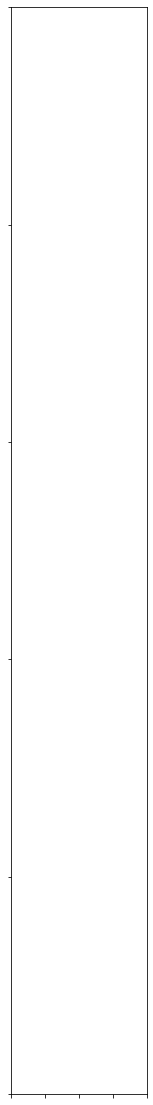

In [4]:
plt.rcParams["axes.grid"] = False

# Visualize the original image and the gradients
fig = plt.figure(figsize=(20, 20))

num_images = 7

# Original image
ax = fig.add_subplot(1, num_images, 1)
ax.set_yticklabels([])
ax.set_xticklabels([])
image.requires_grad_(False)
img_np = np.transpose(image.cpu().numpy() / 2 + 0.5, (1, 2, 0))
ax.imshow(img_np)
ax.set_title("Image: {}".format(label))

# Gradcam
cam_img = normalize_gradient_image(cam)
cam_img *= 255
cam_img = Image.fromarray(cam_img.astype("uint8"))
ax = fig.add_subplot(1, num_images, 2)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(cam_img)
ax.set_title("GradCam")

# Grayscale gradcam
grayscale_cam = convert_to_grayscale(np.expand_dims(cam,0))
grayscale_cam = np.repeat(grayscale_cam, 3, axis=0)
grayscale_cam *= 255
grayscale_cam = Image.fromarray(grayscale_cam.astype("uint8").transpose(1, 2, 0))
ax = fig.add_subplot(1, num_images, 3)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(grayscale_cam)
ax.set_title("Grayscale GradCam")

# Smoothgrad
saliency_img = normalize_gradient_image(smooth_saliency)
saliency_img *= 255
saliency_img = Image.fromarray(saliency_img.astype("uint8").transpose(1, 2, 0))
ax = fig.add_subplot(1, num_images, 4)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(saliency_img)
ax.set_title("SmoothGrad")

# Grayscale smoothgrad
grayscale_saliency_img = convert_to_grayscale(smooth_saliency)
grayscale_saliency_img = np.repeat(grayscale_saliency_img, 3, axis=0)
grayscale_saliency_img *= 255
grayscale_saliency_img = Image.fromarray(grayscale_saliency_img.astype("uint8").transpose(1, 2, 0))
ax = fig.add_subplot(1, num_images, 5)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(grayscale_saliency_img)
ax.set_title("Grayscale SmoothGrad")

# Guided Backprop
guided_grads_img = normalize_gradient_image(guided_grads)
guided_grads_img *= 255
guided_grads_img = Image.fromarray(guided_grads_img.astype("uint8").transpose(1, 2, 0))
ax = fig.add_subplot(1, num_images, 6)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(guided_grads_img)
ax.set_title("GuidedBackprop")

# Grayscale smoothgrad
grayscale_guided_grads_img = convert_to_grayscale(guided_grads)
grayscale_guided_grads_img = np.repeat(grayscale_guided_grads_img, 3, axis=0)
grayscale_guided_grads_img *= 255
grayscale_guided_grads_img = Image.fromarray(grayscale_guided_grads_img.astype("uint8").transpose(1, 2, 0))
ax = fig.add_subplot(1, num_images, 7)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(grayscale_guided_grads_img)
ax.set_title("Grayscale GuidedBackprop")

print()


## Fast Gradient Sign Method (FGSM)

In [ ]:
class AttackFGSM:
    def __init__(self, targeted=True, max_epsilon=0.21, min_epsilon=1e-10, norm=2,  # also supports 'inf'
                 optimize_epsilon=True, num_iter=None, cuda=True, debug=False):
        self.targeted = targeted
        self.eps = max_epsilon
        self.norm = float(norm)
        self.optimize_epsilon = optimize_epsilon
        if self.optimize_epsilon:
            self.num_iter = num_iter or 10

        self.loss_fn = torch.nn.CrossEntropyLoss()
        if cuda:
            self.loss_fn = self.loss_fn.cuda()
        self.debug = debug

    def generate_ad_ex(self, model, inputs, labels=None, targets=None, batch_num=0):  # Targets are not one hot encoded
        outputs = model(inputs)

        if outputs.is_cuda:
            idxout = torch.LongTensor(range(outputs.size()[0])).cuda()
            xones = torch.ones(outputs.size()[0]).cuda()
        else:
            idxout = torch.LongTensor(range(outputs.size()[0]))
            xones = torch.ones(outputs.size()[0])

        if self.targeted:
            attack_loss = outputs[idxout, targets]
        else:
            # negative sign below gives us correct direction for attack
            attack_loss = -1*outputs[idxout, labels]

        attack_loss.backward(xones)
        grad_sign = torch.sign(inputs.grad)
        delta = self.eps * grad_sign
        ad_inputs = inputs + delta

        return ad_inputs

    def update_eps(self, epsilon):
      self.eps = epsilon

# Experiments

In [ ]:
# Read in the training & testing data with batch size 1
batch_size = 1
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

## Helpers

In [ ]:
class GradientVisualizer:
  def __init__(self, gradcam, guidedbp, smoothgrad):
    self.gradcam = gradcam
    self.guidedbp = guidedbp
    self.smoothgrad = smoothgrad

  def guided_grads(self, grad_mask, guided_backprop_mask):
    """
        Guided gradcam/smoothgrad is just pointwise multiplication of grad mask and
        guided backprop mask
    Args:
        grad_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    grad_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return grad_gb

  def get_saliency_maps(self, processed_image, target, include_colour=False, gradients_only=False):
    # Compute gradient maps for gradcam, guidedbp, and smoothgrad
    gradcam_mask = self.gradcam.generate_cam(processed_image, target)    
    guidedbp_mask = self.guidedbp.generate_gradients(processed_image, target)
    smoothgrad_mask = self.smoothgrad.generate_gradients(processed_image, target)
    gradients = [gradcam_mask, guidedbp_mask, smoothgrad_mask]

    if gradients_only:
      return gradients
      
    # Compute gradient maps for guided gradcam and guided smoothgrad
    # guided_gradcam_mask = self.guided_grads(gradcam_mask, guided_backprop_mask)
    # guided_smoothgrad_mask = self.guided_grads(smoothgrad_mask, guided_bp_mask)

    # Convert gradient masks to images for visualization
    saliency_maps = []
    for grad_mask in gradients:
      if include_colour:
        grad_image = self.get_images_from_gradients(grad_mask)
        saliency_maps.append(grad_image)
      grad_image_grey = self.get_images_from_gradients(grad_mask, greyscale=True)
      saliency_maps.append(grad_image_grey)

    return gradients, saliency_maps

  def get_images_from_gradients(self, grad_mask, greyscale=False):
    if greyscale:
      if len(grad_mask.shape) == 2:
        grad_mask = np.expand_dims(grad_mask, 0)
      grad_image = convert_to_grayscale(grad_mask)
      grad_image = np.repeat(grad_image, 3, axis=0)
    else:
      grad_image = normalize_gradient_image(grad_mask)
    
    grad_image *= 255
    if len(grad_image.shape) == 2:
      grad_image = Image.fromarray(grad_image.astype("uint8"))
    else:
      grad_image = Image.fromarray(grad_image.astype("uint8").transpose(1, 2, 0))
    return grad_image


# Helper for visualizing list of images in PyTorch
def display_images(image_list, title_list, fig_size=(15, 15)):
  assert(len(image_list) == len(title_list))
  
  fig = plt.figure(figsize=fig_size)
  numCols = len(image_list)

  for imageIdx in range(numCols):

    ax = fig.add_subplot(1, numCols, imageIdx+1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(image_list[imageIdx])
    ax.set_title(title_list[imageIdx])

In [8]:
# Eval Metrics
import scipy.stats as stats
from skimage.metrics import structural_similarity as ssim
from skimage.feature import hog
from skimage import exposure
import pickle

def eval_maps(true_pred, advers_pred):
  if len(true_pred.shape) == 3:
    true_pred = true_pred.transpose(1, 2, 0)
  if len(advers_pred.shape) == 3:
    advers_pred = advers_pred.transpose(1, 2, 0)
  if len(true_pred.shape) == 2:
    true_pred = np.repeat(np.expand_dims(true_pred, axis=2), 3, axis=2)
  if len(advers_pred.shape) == 2:
    advers_pred = np.repeat(np.expand_dims(advers_pred, axis=2), 3, axis=2)

  # Spearman rank correlation
  spearman, p_val1 = stats.spearmanr(true_pred.reshape(-1), advers_pred.reshape(-1))
  # print(f"Spearman rank corr:  {spearman} (p-value) {p_val1}")

  mssim = ssim(true_pred, advers_pred, multichannel=True)
  # print(f"Mean SSIM         :  {mssim}") # over image

  fd, true_hog = hog(true_pred, orientations=9, pixels_per_cell=(16, 16),
                     cells_per_block=(1, 1), visualize=True, multichannel=True)
  fd, advers_hog = hog(advers_pred, orientations=9, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=True, multichannel=True)

  pearson, p_val2 = stats.pearsonr(true_hog.reshape(-1), advers_hog.reshape(-1))
  # print(f"Pearson of HoG    :  {pearson} (p-value) {p_val2}")
  
  # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

  # Rescale histogram for better display
  # hog_image_rescaled = exposure.rescale_intensity(true_hog, in_range=(0, 10))

  # ax1.axis('off')
  # ax1.imshow(hog_image_rescaled, cmap=plt.cm.gray)
  # ax1.set_title('HoGs True')

  # hog_image_rescaled = exposure.rescale_intensity(advers_hog, in_range=(0, 10))

  # ax2.axis('off')
  # ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
  # ax2.set_title('HoGs Pred')
  # plt.show()

  return spearman, mssim, pearson

In [ ]:
# Load pretrained model
pretrained_model = net  # Loaded before

# Set up visualizers: grad cam, guided backprop, smoothgrad
gradcam = GradCam(pretrained_model, target_layer=11)
guidedbp = GuidedBackprop(pretrained_model)
smoothgrad = SmoothGrad(pretrained_model, cuda=torch.cuda.is_available(),
                        n_samples=3,
                        magnitude=True)

# Create GradientVisualizer class
Visualizer = GradientVisualizer(gradcam, guidedbp, smoothgrad)

## Untargeted attacks

In [ ]:
# Create fast gradient sign method attack (untargeted)
fgs = AttackFGSM(targeted=False, optimize_epsilon=False, max_epsilon=1.5)

# Evaluation list
eps_list = [0.2, 0.4, 0.6, 0.8, 1.0]
gradcam_dict = dict(zip(eps_list, [[], [], [], [], []]))
guidedbackprop_dict = dict(zip(eps_list, [[], [], [], [], []]))
smoothgrad_dict = dict(zip(eps_list, [[], [], [], [], []]))

# Generate predictions for test images
for i, (images, labels) in enumerate(testloader):
    if i % 10 == 0:
        print('Iter {}/{}'.format(i, len(testloader)))

    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    predicted = torch.argmax(outputs, dim=1)

    # Extract sample
    image = images[0].unsqueeze(0)
    orig_pred = predicted[0]

    # Plotting
    if i == 1:
        print("Original class prediction: {}".format(orig_pred))

        image_list = [np.transpose(image[0].cpu().numpy() / 2 + 0.5, (1, 2, 0))]

        image.requires_grad_(True)
        # Compute saliency maps for original predictions
        gradients_orig, saliency_maps_orig = Visualizer.get_saliency_maps(image, orig_pred)
        image_list.extend(saliency_maps_orig)
        display_images(image_list, ["Original Image", 
                                    "Original GradCam",
                                    "Original Guided Backprop",
                                    "Original SmoothGrad"])
        # Adversarial attack
        for eps in eps_list:
            fgs.update_eps(eps)
            perturbed_image = fgs.generate_ad_ex(pretrained_model, image, labels=orig_pred)
            perturbed_output = pretrained_model(perturbed_image)
            _, adv_pred = torch.max(perturbed_output.data, 1)
            print("Perturbed class prediction: {}".format(adv_pred.item()))

            # Compute saliency maps for adversarial predictions
            gradients_adv, saliency_maps_adv = Visualizer.get_saliency_maps(perturbed_image, adv_pred)

            perturbed_image = normalize_gradient_image(perturbed_image)
            image_list = [np.transpose(perturbed_image[0].detach().numpy(), (1, 2, 0))]
            image_list.extend(saliency_maps_adv)
            display_images(image_list, ["Perturbed Image: {}".format(eps), 
                                        "Perturbed GradCam",
                                        "Perturbed Guided Backprop",
                                        "Perturbed SmoothGrad"])
    
    image.requires_grad_(True)
    # Compute saliency maps for original predictions
    gradients_orig = Visualizer.get_saliency_maps(image, orig_pred, gradients_only=True)

    # Adversarial attack
    for eps in eps_list:
        fgs.update_eps(eps)
        perturbed_image = fgs.generate_ad_ex(pretrained_model, image, labels=orig_pred)
        perturbed_output = pretrained_model(perturbed_image)
        _, adv_pred = torch.max(perturbed_output.data, 1)
        # Compute saliency maps for adversarial predictions
        gradients_adv = Visualizer.get_saliency_maps(perturbed_image, adv_pred, gradients_only=True)

        # Compute evaluation metrics
        for true_pred, advers_pred, eval_dict in zip(gradients_orig, gradients_adv, 
                                                      [gradcam_dict, guidedbackprop_dict, smoothgrad_dict]):
            eval_dict[eps].append(eval_maps(true_pred, advers_pred))
  

In [ ]:
# Save the evaluation dictionaries
path = os.path.join(checkpoint_dir, "untargeted_eval.pkl")
untargeted_eval = dict(zip(['gradcam', 'guidedbackprop', 'smoothgrad'],
                           [gradcam_dict, guidedbackprop_dict, smoothgrad_dict]))
with open(path, 'wb') as handle:
    pickle.dump(untargeted_eval, handle, protocol=pickle.HIGHEST_PROTOCOL)


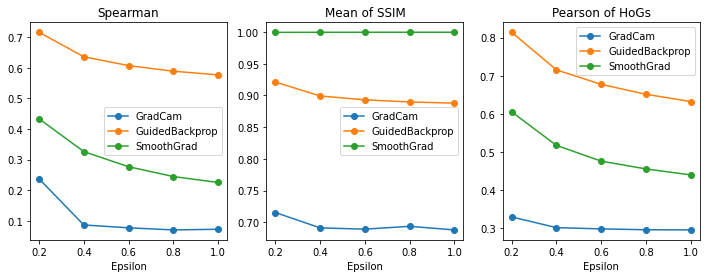

In [16]:
import matplotlib.pyplot as plt

# Uncomment if need to load from presaved untargeted_eval
# Format is: {'gradcam': gradcam_dict, ...}
path = os.path.join(checkpoint_dir, "untargeted_eval.pkl")
with open(path, 'rb') as handle:
    untargeted_eval = pickle.load(handle)

eps_list = [0.2, 0.4, 0.6, 0.8, 1.0]

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 3, 1)
ax1.set_title('Spearman')
ax1.set_xlabel('Epsilon')
ax2 = plt.subplot(1, 3, 2)
ax2.set_title('Mean of SSIM')
ax2.set_xlabel('Epsilon')
ax3 = plt.subplot(1, 3, 3)
ax3.set_title('Pearson of HoGs')
ax3.set_xlabel('Epsilon')

for eval_method, eval_dict in untargeted_eval.items():
    spearman_mean, mssim_mean, pearson_mean = [], [], []
    for key, val in eval_dict.items():
        # print('Epsilon: {}'.format(key))
        n = len(val)
        spearman, mssim, pearson = 0, 0, 0
        for x in val:
            spearman += x[0]
            mssim += x[1]
            pearson += x[2]
        # Store means
        spearman_mean.append(spearman / n)
        mssim_mean.append(mssim / n)
        pearson_mean.append(pearson /n)
    
    # Plotting
    ax1.plot(eps_list, spearman_mean, '-o')
    ax2.plot(eps_list, mssim_mean, '-o')
    ax3.plot(eps_list, pearson_mean, '-o')

ax1.legend(['GradCam', 'GuidedBackprop', 'SmoothGrad'])
ax2.legend(['GradCam', 'GuidedBackprop', 'SmoothGrad'])
ax3.legend(['GradCam', 'GuidedBackprop', 'SmoothGrad'])

plt.show()

## Targeted attacks

In [ ]:
# Create fast gradient sign method attack (untargeted)
fgs = AttackFGSM(targeted=True, optimize_epsilon=False, max_epsilon=1.5)

# Evaluation list
eps = 0.8  # 0.4, 0.6
targets_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
gradcam_dict = dict(zip(targets_list, [[], [], [], [], [], [], [], [], [], []]))
guidedbackprop_dict = dict(zip(targets_list, [[], [], [], [], [], [], [], [], [], []]))
smoothgrad_dict = dict(zip(targets_list, [[], [], [], [], [], [], [], [], [], []]))

# Generate predictions for test images
for i, (images, labels) in enumerate(testloader):
    if i % 10 == 0:
        print('Iter {}/{}'.format(i, len(testloader)))

    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    predicted = torch.argmax(outputs, dim=1)

    # Extract sample
    image = images[0].unsqueeze(0)
    orig_pred = predicted[0]

    # Plotting
    if i == 1:
        print("Original class prediction: {}".format(orig_pred))

        image_list = [np.transpose(image[0].cpu().numpy() / 2 + 0.5, (1, 2, 0))]

        image.requires_grad_(True)
        # Compute saliency maps for original predictions
        gradients_orig, saliency_maps_orig = Visualizer.get_saliency_maps(image, orig_pred)
        image_list.extend(saliency_maps_orig)
        display_images(image_list, ["Original Image", 
                                    "Original GradCam",
                                    "Original Guided Backprop",
                                    "Original SmoothGrad"])
        # Adversarial attack
        for target in targets_list:
            fgs.update_eps(eps)
            perturbed_image = fgs.generate_ad_ex(pretrained_model, image, targets=target)
            perturbed_output = pretrained_model(perturbed_image)
            _, adv_pred = torch.max(perturbed_output.data, 1)
            print("Perturbed class prediction: {}".format(adv_pred.item()))

            # Compute saliency maps for adversarial predictions
            gradients_adv, saliency_maps_adv = Visualizer.get_saliency_maps(perturbed_image, adv_pred)

            perturbed_image = normalize_gradient_image(perturbed_image)
            image_list = [np.transpose(perturbed_image[0].detach().numpy(), (1, 2, 0))]
            image_list.extend(saliency_maps_adv)
            display_images(image_list, ["Perturbed Image: {}".format(eps), 
                                        "Perturbed GradCam",
                                        "Perturbed Guided Backprop",
                                        "Perturbed SmoothGrad"])
    if i == 100:
        break 
    
    image.requires_grad_(True)
    # Compute saliency maps for original predictions
    gradients_orig = Visualizer.get_saliency_maps(image, orig_pred, gradients_only=True)

    # Adversarial attack
    for target in targets_list:
        fgs.update_eps(eps)
        perturbed_image = fgs.generate_ad_ex(pretrained_model, image, targets=target)
        perturbed_output = pretrained_model(perturbed_image)
        _, adv_pred = torch.max(perturbed_output.data, 1)
        # Compute saliency maps for adversarial predictions
        gradients_adv = Visualizer.get_saliency_maps(perturbed_image, adv_pred, gradients_only=True)

        # Compute evaluation metrics
        for true_pred, advers_pred, eval_dict in zip(gradients_orig, gradients_adv, 
                                                      [gradcam_dict, guidedbackprop_dict, smoothgrad_dict]):
            eval_dict[target].append(eval_maps(true_pred, advers_pred))
  

In [105]:
# Save the evaluation dictionaries
eps = 0.4
path = os.path.join(checkpoint_dir, "targeted_eval_{}.pkl".format(eps))
targeted_eval = dict(zip(['gradcam', 'guidedbackprop', 'smoothgrad'],
                        [gradcam_dict, guidedbackprop_dict, smoothgrad_dict]))
with open(path, 'wb') as handle:
    pickle.dump(targeted_eval, handle, protocol=pickle.HIGHEST_PROTOCOL)


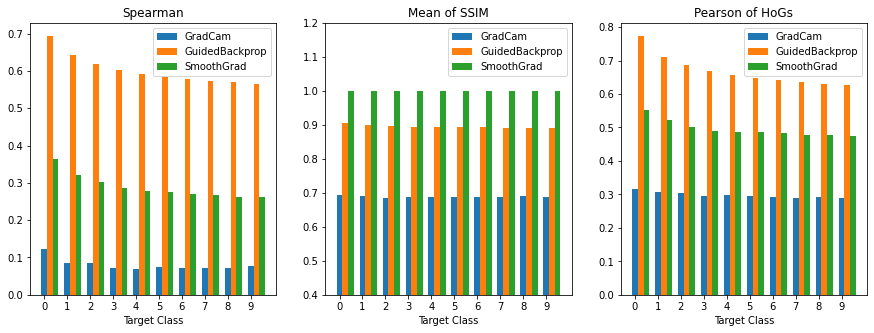

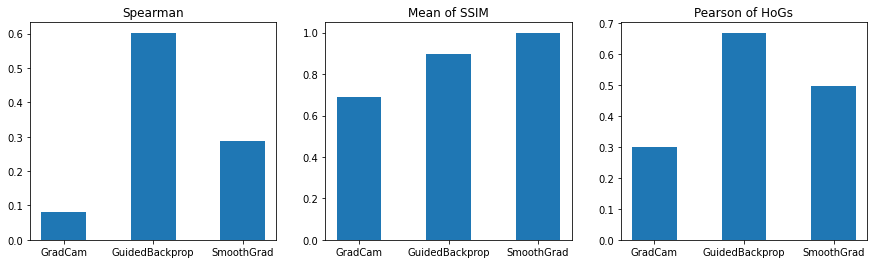

Spearman means: [0.08038807529084768, 0.6023638591103293, 0.2883910456899045]
Mssim means: [0.6890307446734655, 0.895180532350231, 0.9996472161174383]
Pearson means: [0.29812394705001555, 0.6680725612446645, 0.4953517437759748]


In [9]:
import matplotlib.pyplot as plt

# Uncomment if need to load from presaved targeted_eval
# Format is: {'gradcam': gradcam_dict, ...}
eps = 0.4
path = os.path.join(checkpoint_dir, "targeted_eval_{}.pkl".format(eps))
with open(path, 'rb') as handle:
    targeted_eval = pickle.load(handle)

targets_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

fig1 = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
ax1.set_title('Spearman')
ax1.set_xlabel('Target Class')
ax1.set_xticks(targets_list)
ax2 = plt.subplot(1, 3, 2)
ax2.set_title('Mean of SSIM')
ax2.set_xlabel('Target Class')
ax2.set_xticks(targets_list)
ax2.set_ylim([0.4, 1.2])
ax3 = plt.subplot(1, 3, 3)
ax3.set_title('Pearson of HoGs')
ax3.set_xlabel('Target Class')
ax3.set_xticks(targets_list)
targets_arr = np.asarray(targets_list)

fig2 = plt.figure(figsize=(15, 4))
ax4 = plt.subplot(1, 3, 1)
ax4.set_title('Spearman')
ax5 = plt.subplot(1, 3, 2)
ax5.set_title('Mean of SSIM')
ax6 = plt.subplot(1, 3, 3)
ax6.set_title('Pearson of HoGs')
targets_mean_arr = np.arange(3)

eval_mean_over_targets= []
for idx, (eval_method, eval_dict) in enumerate(targeted_eval.items()):
    spearman_mean, mssim_mean, pearson_mean = [], [], []
    for key, val in eval_dict.items():
        # print('Target: {}'.format(key))
        n = len(val)
        spearman, mssim, pearson = 0, 0, 0
        for x in val:
            spearman += x[0]
            mssim += x[1]
            pearson += x[2]
        # Store means
        spearman_mean.append(spearman / n)
        mssim_mean.append(mssim / n)
        pearson_mean.append(pearson /n)
    
    # Plotting
    ax1.bar(targets_arr+0.25*idx, spearman_mean, width=0.25)
    ax2.bar(targets_arr+0.25*idx, mssim_mean, width=0.25)
    ax3.bar(targets_arr+0.25*idx, pearson_mean, width=0.25)

    # Save mean over target classes
    eval_mean_over_targets.append([sum(spearman_mean)/10, sum(mssim_mean)/10, sum(pearson_mean)/10])

# Plot mean over target classes
spearman_mean = [x[0] for x in eval_mean_over_targets]
mssim_mean = [x[1] for x in eval_mean_over_targets]
pearson_mean = [x[2] for x in eval_mean_over_targets]
ax4.bar(['GradCam', 'GuidedBackprop', 'SmoothGrad'], spearman_mean, width=0.5)
ax5.bar(['GradCam', 'GuidedBackprop', 'SmoothGrad'], mssim_mean, width=0.5)
ax6.bar(['GradCam', 'GuidedBackprop', 'SmoothGrad'], pearson_mean, width=0.5)

ax1.legend(['GradCam', 'GuidedBackprop', 'SmoothGrad'])
ax2.legend(['GradCam', 'GuidedBackprop', 'SmoothGrad'])
ax3.legend(['GradCam', 'GuidedBackprop', 'SmoothGrad'])

plt.show()

print('Spearman means: {}'.format(spearman_mean))
print('Mssim means: {}'.format(mssim_mean))
print('Pearson means: {}'.format(pearson_mean))